https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
pd.options.display.max_rows = 4000
pd.options.display.max_colwidth = 1000
# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
from gensim.models import Word2Vec

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [25]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [6]:
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv', encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df.shape

(1600000, 6)

In [7]:
df.head(2)

target         ids                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   

              user  \
0  _TheSpecialOne_   
1    scotthamilton   

                                                                                                                  text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
1      is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!

In [12]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]
df.target = df.target.apply(lambda x: decode_sentiment(x))

Text(0.5,1,'Dataset labels distribuition')

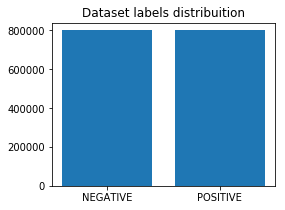

In [14]:
target_cnt = Counter(df.target)

plt.figure(figsize=(4,3))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Datensatz repräsentativ splitten

In [57]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=100, test_size=200, train_size=1000, random_state=42)
for train_index, test_index in split.split(df, df['target']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]
    break;
print("Train set {0}".format(train_set.shape))
print("Test set {0}".format(test_set.shape))

Train set (1000, 6)
Test set (200, 6)


Text(0.5,1,'Train set labels distribuition')

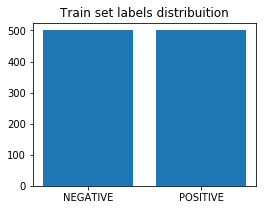

In [58]:
target_cnt = Counter(train_set.target)

plt.figure(figsize=(4,3))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Train set labels distribuition")

Text(0.5,1,'Train set labels distribuition')

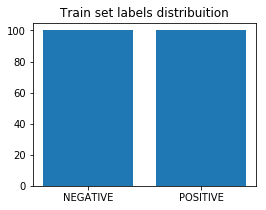

In [59]:
target_cnt = Counter(test_set.target)

plt.figure(figsize=(4,3))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Train set labels distribuition")

In [60]:
X = pad_sequences(tokenizer.texts_to_sequences(train_set.text), maxlen=SEQUENCE_LENGTH)
Y = encoder.transform(train_set.target.tolist())
Y = Y.reshape(-1,1)
print("X {0}".format(X.shape))
print("Y {0}".format(Y.shape))

X (1000, 300)
Y (1000, 1)


## W2V Modell, Tokenizer und Encoder laden

In [61]:
w2v_model = Word2Vec.load(WORD2VEC_MODEL)
tokenizer = pickle.load(open(TOKENIZER_MODEL, "rb"))
encoder = pickle.load(open(ENCODER_MODEL, "rb"))
vocab_size = len(tokenizer.word_index) + 1

2019-02-10 12:11:52,400 : INFO : loading Word2Vec object from model.w2v
2019-02-10 12:11:53,494 : INFO : loading wv recursively from model.w2v.wv.* with mmap=None
2019-02-10 12:11:53,503 : INFO : setting ignored attribute vectors_norm to None
2019-02-10 12:11:53,514 : INFO : loading vocabulary recursively from model.w2v.vocabulary.* with mmap=None
2019-02-10 12:11:53,542 : INFO : loading trainables recursively from model.w2v.trainables.* with mmap=None
2019-02-10 12:11:53,549 : INFO : setting ignored attribute cum_table to None
2019-02-10 12:11:53,566 : INFO : loaded model.w2v


## Modell

In [62]:
def create_model():
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
      if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
    print(embedding_matrix.shape)
    
    embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
    
    return model

## Grid Search

In [63]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [64]:
model = KerasClassifier(build_fn=create_model, verbose=0)

In [65]:
%%time
# define the grid search parameters
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y)

(290419, 300)
(290419, 300)
(290419, 300)
(290419, 300)


KeyboardInterrupt: 